In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818/1-223.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/2-089.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/1-111.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/1-051.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/2-203.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/1-213.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.

In [2]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-25 05:09:56.362038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 05:09:56.362146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 05:09:56.516609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **EDA**

In [3]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

SeriesInstanceUID  \
0  1.3.6.1.4.1.9590.100.1.2.117041576511324414842...   
1  1.3.6.1.4.1.9590.100.1.2.438738396107617880132...   
2  1.3.6.1.4.1.9590.100.1.2.767416741131676463382...   
3  1.3.6.1.4.1.9590.100.1.2.296931352612305599800...   
4  1.3.6.1.4.1.9590.100.1.2.436657670120353100077...   

                                    StudyInstanceUID Modality  \
0  1.3.6.1.4.1.9590.100.1.2.229361142710768138411...       MG   
1  1.3.6.1.4.1.9590.100.1.2.195593486612988388325...       MG   
2  1.3.6.1.4.1.9590.100.1.2.257901172612530623323...       MG   
3  1.3.6.1.4.1.9590.100.1.2.109468616710242115222...       MG   
4  1.3.6.1.4.1.9590.100.1.2.380627129513562450304...       MG   

  SeriesDescription BodyPartExamined  SeriesNumber Collection  Visibility  \
0   ROI mask images           BREAST             1  CBIS-DDSM           1   
1   ROI mask images           BREAST             1  CBIS-DDSM           1   
2   ROI mask images           BREAST             1  CBIS-DDSM           1   
3   ROI mask images           BREAST             1  CBIS-DDSM           1   
4   ROI mask images           BREAST             1  CBIS-DDSM           1   

   ImageCount  
0           2  
1           2  
2           2  
3           2  
4           2

In [4]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


In [5]:
# load dicom info file
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   
3             16          16           BREAST       97     20160503   
4              8           8      Left Breast     3104     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   
3   115347.770            WSD  ...   
4   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   
3                   32298            ISO_IR 100  20170829.0    DDSM   
4                       0            ISO_IR 100         NaN    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  
3  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...   180109.0  
4  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...        NaN  

[5 rows x 38 columns]

In [6]:
df_dicom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [7]:
# check image types in dataset
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [8]:
# check image path in dataset
# cropped images
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(5)

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [9]:
#full mammogram images
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
# ROI images
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [11]:
# set correct image path for image types
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [12]:
# change directory path of images
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [13]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [14]:
# load the mass dataset
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [15]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)

In [16]:
# check unique values in pathology column
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [17]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [18]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [19]:
# check for null values
mass_train.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [20]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [21]:
# quantitative summary of features
mass_train.describe()

breast_density  abnormality_id   assessment     subtlety
count     1318.000000     1318.000000  1318.000000  1318.000000
mean         2.203338        1.116085     3.504552     3.965857
std          0.873774        0.467013     1.414609     1.102032
min          1.000000        1.000000     0.000000     0.000000
25%          2.000000        1.000000     3.000000     3.000000
50%          2.000000        1.000000     4.000000     4.000000
75%          3.000000        1.000000     4.000000     5.000000
max          4.000000        6.000000     5.000000     5.000000

In [22]:
# view mass_test
mass_test.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image file path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped image file path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI mask file path  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....

In [23]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [24]:
mass_test.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [25]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [26]:
# fill in missing values using the backwards fill method
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

### Data visualization

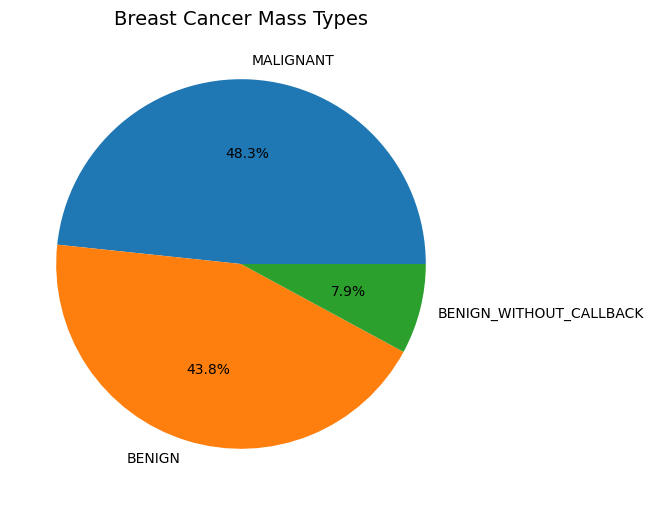

In [27]:
# pathology distributions
value = mass_train['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.savefig('/kaggle/working/pathology_distributions_red.png')
plt.show()

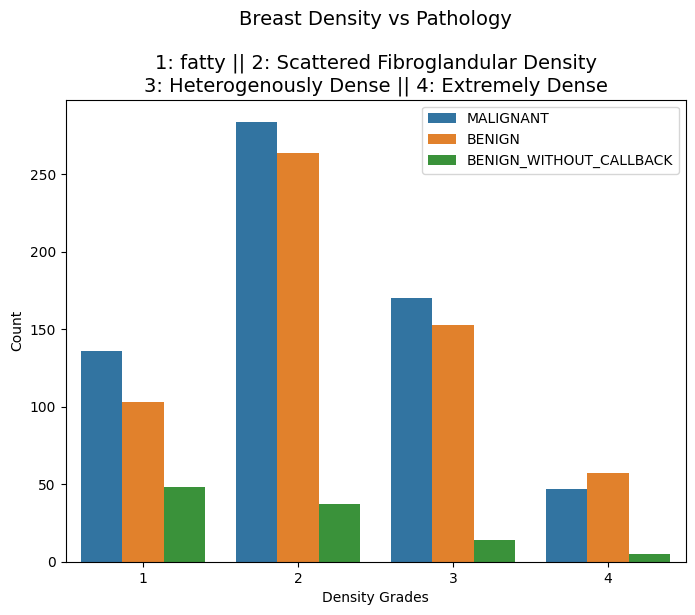

In [28]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/kaggle/working/density_pathology_red.png')
plt.show()

Full Mammograms:



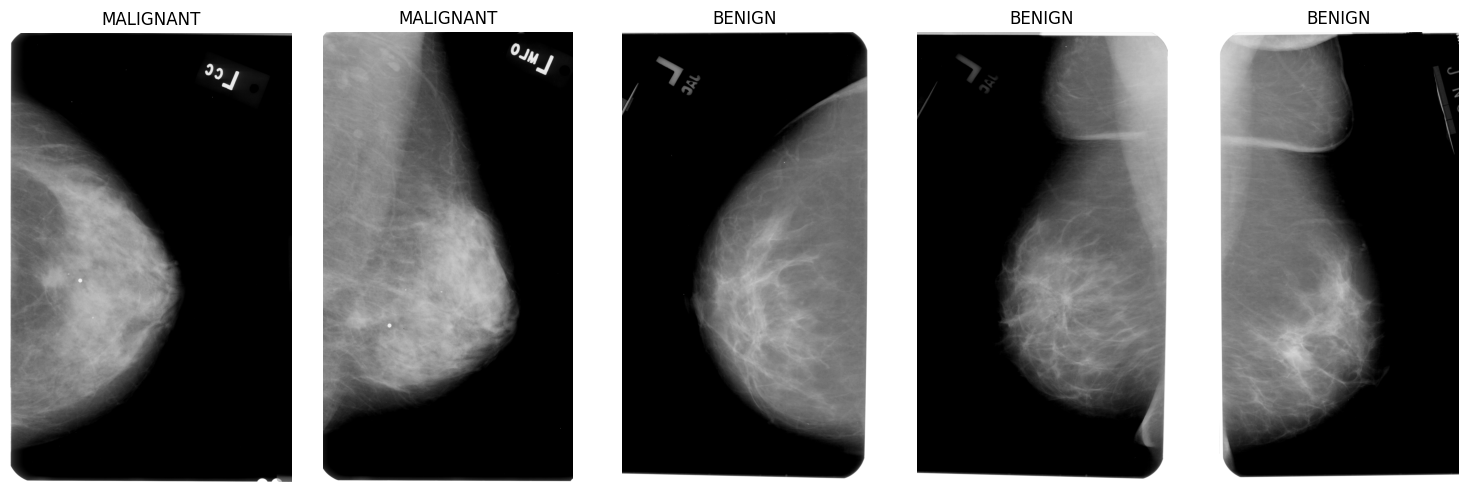

Cropped Mammograms:



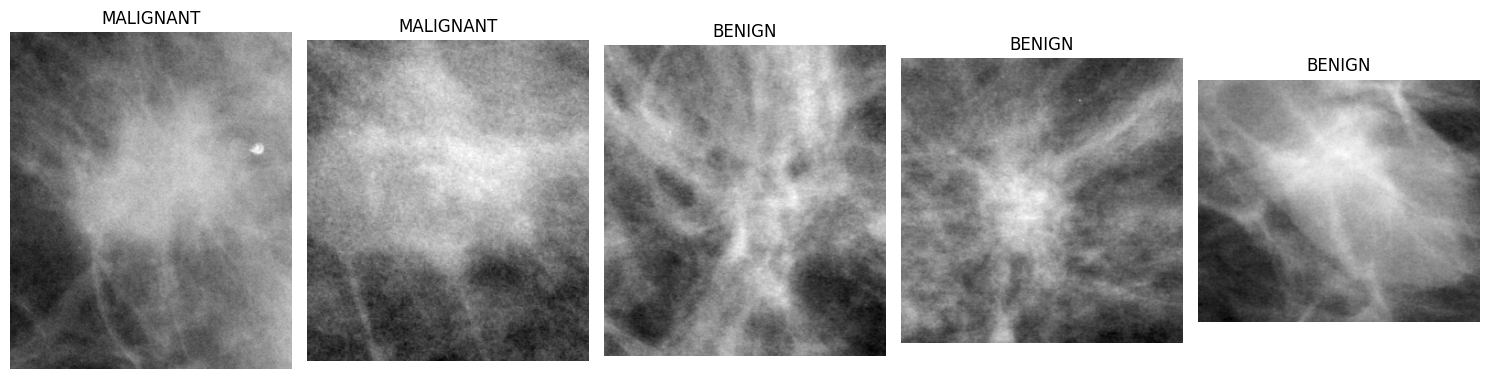

In [29]:
# create function to display images
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

## **Preprocessing**

In [30]:
#second preprocessing
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image
    image = cv2.resize(image, (target_size[1], target_size[0]))
    
    # Histogram Equalization
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    image = cv2.merge((l_channel, a_channel, b_channel))
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    
     #Negative transformation
    image = 255 - image
    
     #Rescale to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image

In [31]:
# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

In [32]:
# Define the target size
target_size = (224, 224, 3)

In [33]:
# Sample a subset of images
sample_size = 1696  # Adjust the sample size as needed
full_mass_sample = full_mass.sample(n=sample_size, random_state=42)

In [34]:
# Apply preprocessor to train data
full_mass_sample['processed_images'] = full_mass_sample['image_file_path'].apply(lambda x: image_processor(x, target_size))

In [35]:
# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [36]:
# Convert the processed_images column to an array
X_resized = np.array(full_mass_sample['processed_images'].tolist())

In [37]:
# Apply class mapper to pathology column
full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)

/tmp/ipykernel_34/1657496192.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)


In [38]:
# Check the number of classes
num_classes = len(full_mass_sample['labels'].unique())

In [39]:
from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 5  # For example, 5-fold cross-validation

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the data for cross-validation
X = np.array(full_mass_sample['processed_images'].tolist())  # Features
y = full_mass_sample['labels'].values  # Labels

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{n_splits}")
    
    # Split the data into training and test sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)
    batch_size=20
    # Generate augmented data in batches
    augmented_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Now you can fit your model on the augmented data generator
    # and evaluate it on X_test and y_test
    # Make sure to reset the generator for each fold
    augmented_data_generator.reset()

Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5


### Data Augmentation using ImageDataGenerator

In [40]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1357, 224, 224, 3)
X_test shape: (339, 224, 224, 3)
y_train shape: (1357,)
y_test shape: (339,)


### Visualization of Preprocessed Images

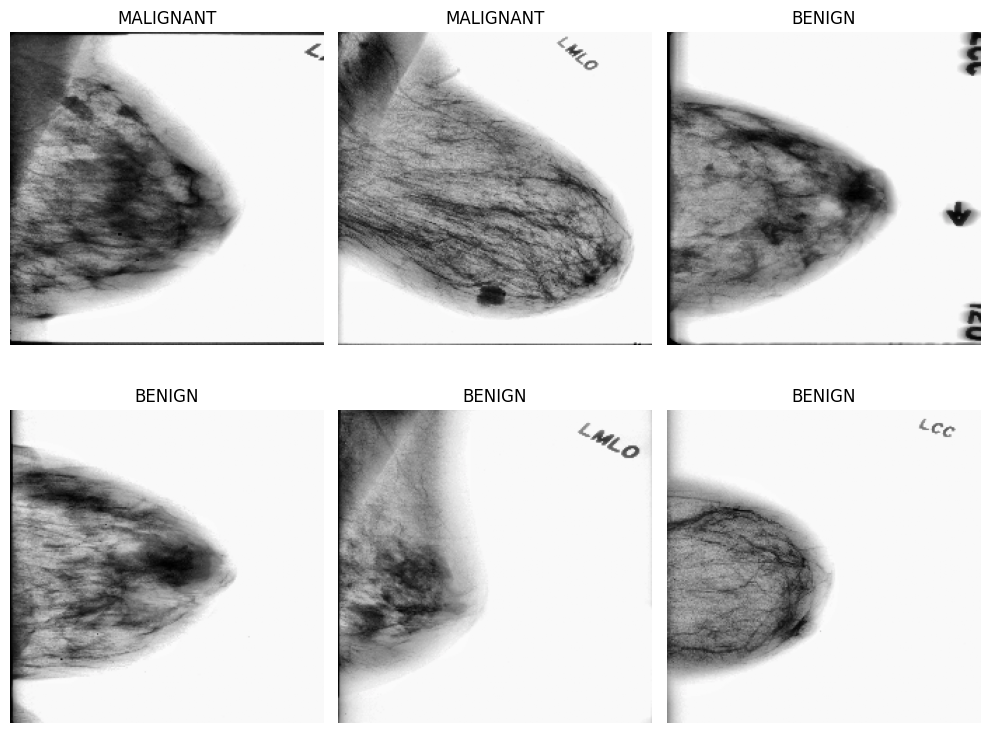

In [41]:
# Define a function to display images
def display_images(images, titles, rows, cols, figsize=(10, 8)):
    """Display a grid of images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of preprocessed images
sample_images = X_train[:6]  # Adjust the number of images to display
sample_labels = y_train[:6]  # Adjust labels accordingly

# Define titles for the images
class_names = ['BENIGN', 'MALIGNANT','BENIGN_WITHOUT_CALLBACK']  # Assuming 0 is benign and 1 is malignant
image_titles = [class_names[label] for label in sample_labels]

# Display the images
display_images(sample_images, image_titles, 2, 3)

In [42]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [43]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l1_l2

In [132]:
# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.3

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='relu')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [133]:
#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [127]:
''''# Define a learning rate scheduler (if needed)
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = initial_learning_rate
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

## **Model Training**

In [134]:
from keras.callbacks import EarlyStopping

In [135]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'path/to/your/checkpoint_directory/model-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [152]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 64
max_epochs = 25
#num_iterations = 200

# Now, include the callback in your model.fit() call
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    #steps_per_epoch=num_iterations,
                    validation_data=(X_test, y_test), 
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint_callback])


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9885 - loss: 20.8769
Epoch 1: val_accuracy did not improve from 0.69617
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - accuracy: 0.9883 - loss: 20.8732 - val_accuracy: 0.6814 - val_loss: 24.7881 - learning_rate: 1.0000e-04
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9839 - loss: 20.4750
Epoch 2: val_accuracy did not improve from 0.69617
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - accuracy: 0.9840 - loss: 20.4683 - val_accuracy: 0.6637 - val_loss: 24.4164 - learning_rate: 1.0000e-04
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9934 - loss: 19.9393
Epoch 3: val_accuracy did not improve from 0.69617
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.9933 - loss: 19.9363 - val_accuracy: 0.6667 - val_loss: 24.0137 - learning_rate: 1.0000e-04
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9928 - loss: 19.4878
Epoch 4: val_accuracy did not improve from 0.69617
22/2

In [154]:
model.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6696 - loss: 20.7803


[20.773193359375, 0.6784660816192627]

### Model Performanace Visualization

In [158]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [159]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [160]:
# Calculate overall training and validation loss and accuracy
overall_train_loss = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss = np.mean(val_loss)
overall_val_accuracy = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.9927781820297241
Overall Validation Accuracy: 0.6737463164329529


In [161]:
model.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6696 - loss: 20.7803


[20.773193359375, 0.6784660816192627]

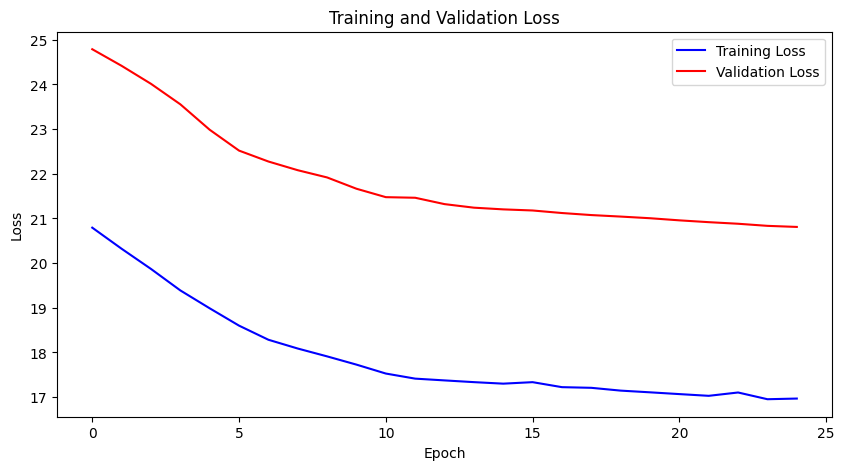

In [162]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

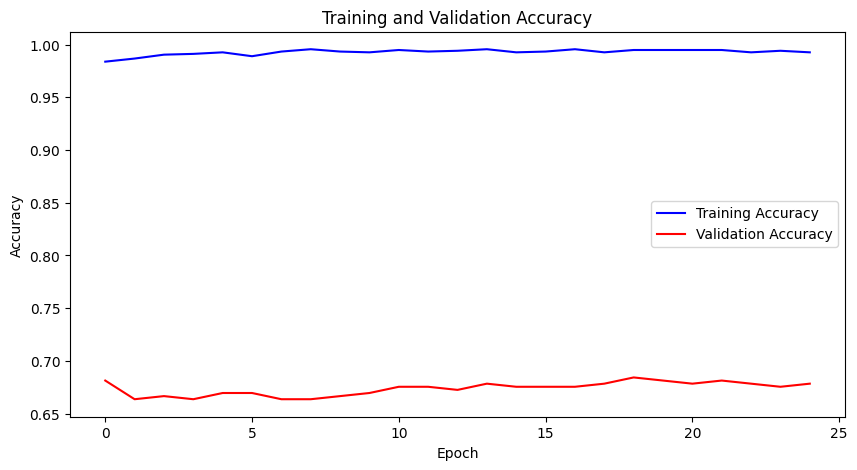

In [163]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [167]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [169]:
# Determine if y_test is one-hot encoded or label-encoded
if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)


In [170]:
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

In [171]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [172]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [174]:
# Print classification report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       173
           1       0.00      0.00      0.00       166

    accuracy                           0.51       339
   macro avg       0.26      0.50      0.34       339
weighted avg       0.26      0.51      0.34       339



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


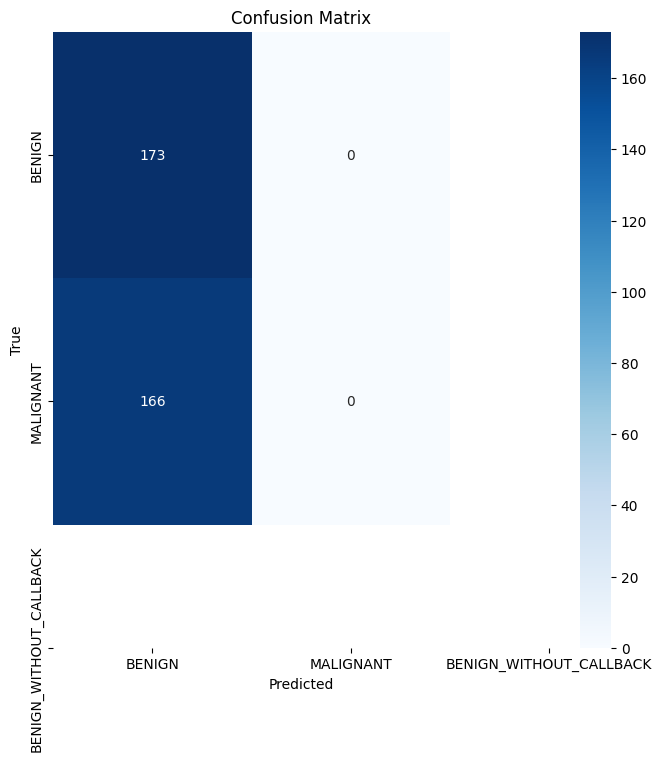

In [175]:
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

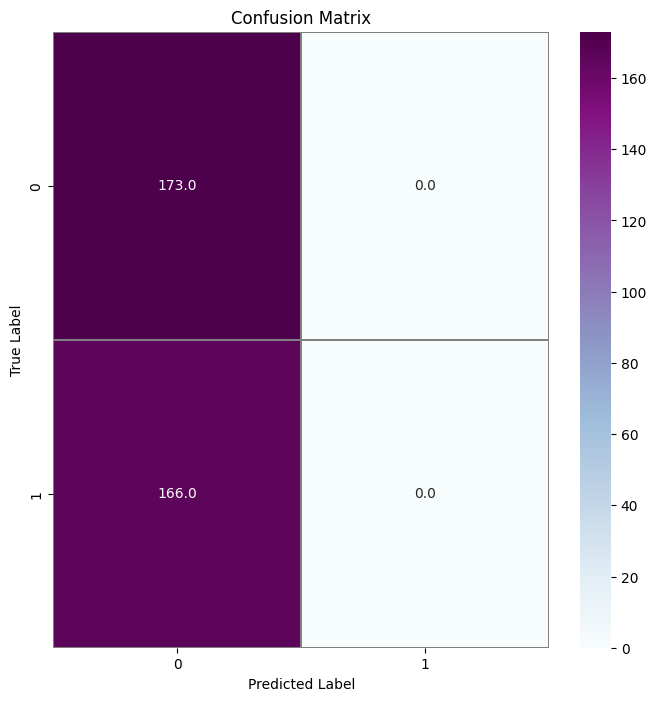

In [176]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Testing the model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


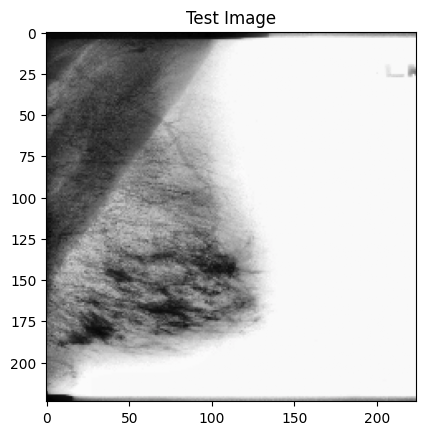

In [177]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

# Define a function for plotting an image from an array
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')
    
    # Display the image at the specified index in the array
    plt.imshow(arr[index])

# Set the index value to 90
index = 200

# Plot an image from the X_test array using the img_plot function
img_plot(X_test, index)

# Extract a single image from X_test based on the specified index
input = X_test[index:index+1]

# Make a prediction using the CNN model and get the class with the highest probability
predicted_class_index = model.predict(input)[0].argmax()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

In [178]:
model.save('CNN_model.h5')

In [179]:
model.save('CNN_model.keras')

**Testing with miniDDSM**

File exists.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


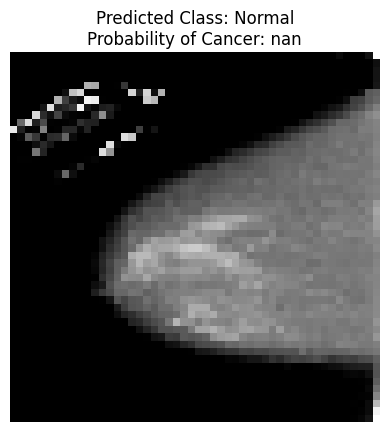

In [180]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# Check if the file exists
#image_path = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Benign/0029/C_0029_1.LEFT_CC.jpg'
image_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547/1-126.jpg'
if not os.path.exists(image_path):
    print("File does not exist.")
else:
    print("File exists.")

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Image not loaded correctly.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
        img = cv2.resize(img, target_size)  # Resize to your target size
        img_array = img / 255.0  # Normalize pixel values

        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Load and preprocess the example image
img_array = load_and_preprocess_image(image_path)

if img_array is not None:
    # Create a batch for prediction (even if it's a single image)
    img_batch = np.expand_dims(img_array, axis=0)

    # Assuming you have a pre-trained model loaded as `model`
    # model = ... (load your model here)

    # Make predictions
    predictions = model.predict(img_batch)

    # Assuming your model predicts binary probabilities, you can get the probability for "Cancer" class
    cancer_probability = predictions[0][0]  # Assuming "Cancer" is the first class

    # Get the predicted class label
    predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

    # Plot the image and display the predicted class and probability
    plt.imshow(img_array)
    plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
    plt.axis('off')
    plt.show()
else:
    print("Image loading and preprocessing failed.")
